In [64]:
from glob import glob
import os
from pathlib import Path
from enum import Enum
import json
import pandas as pd
import seaborn as sns

In [50]:
SYNT_WITH_DEPS_PATH = "../experiments/model-checking/synt-with-deps/"

# Utils

In [51]:
class Status(Enum):
    ERROR = "Error"
    SUCCESS = "Success"
    NOT_FOUND = "Not Found"
    
    def __repr__(self):
        return str(self.value)

In [52]:
def get_all_benchmarks(path):
    hoa_files = glob(os.path.join(path, "*.hoa"))
    names = [
        Path(f).stem
        for f in hoa_files
    ]
    return names
print("Total benchmark of synthesis with dependecy" , len(get_all_benchmarks(SYNT_WITH_DEPS_PATH)))

Total benchmark of synthesis with dependecy 207


In [58]:
def benchmark_loader(algorithm: str, path: str):
    def load_benchmark(name: str):
        base = {
            'algorithm': algorithm,
            'name': name,
        }
        
        json_path = os.path.join(path, name + ".json")
        hoa_path = os.path.join(path, name + ".hoa")
        
        if not os.path.exists(hoa_path):
            return {
                **base,
                'run_status': Status.NOT_FOUND
            }
        
        if not os.path.exists(json_path):
            return {
                **base,
                'run_status': Status.ERROR
            }
        
        with open(json_path, 'r') as f:
            benchmark_json = json.load(f)
        
        model_checking = benchmark_json['synthesis']['model_checking_status']
        realizability = benchmark_json['synthesis']['independent_strategy']['realizability']
        is_completed = benchmark_json['is_completed']
        
        return {
            **base,
            'run_status': Status.SUCCESS,
            'is_completed': is_completed,
            'model_checking': model_checking,
            'realizability': realizability
        }

    return load_benchmark

In [59]:
synt_deps_loader = benchmark_loader('synt-deps', SYNT_WITH_DEPS_PATH)
synt_deps_df = pd.DataFrame([synt_deps_loader(name) for name in get_all_benchmarks(SYNT_WITH_DEPS_PATH)])
synt_deps_df.head(5)

,algorithm,name,run_status,is_completed,model_checking,realizability
0,synt-deps,TwoCountersInRangeA4,Status.SUCCESS,True,UNKNOWN,UNREALIZABLE
1,synt-deps,ltl2dba05,Status.SUCCESS,True,OK,REALIZABLE
2,synt-deps,ltl2dba11,Status.SUCCESS,True,OK,REALIZABLE
3,synt-deps,TwoCountersDisButA6,Status.SUCCESS,True,UNKNOWN,UNREALIZABLE
4,synt-deps,TorcsSteeringSimple,Status.SUCCESS,True,OK,REALIZABLE


# Model Checking Results

In [63]:
print("Total benchmark with running error ", len(synt_deps_df[ synt_deps_df["run_status"] != Status.SUCCESS ]))
print("Total benchmark uncompleted (Timeout) ", len(synt_deps_df[ synt_deps_df["is_completed"] != True ]))

Total benchmark with running error  24
Total benchmark uncompleted (Timeout)  32


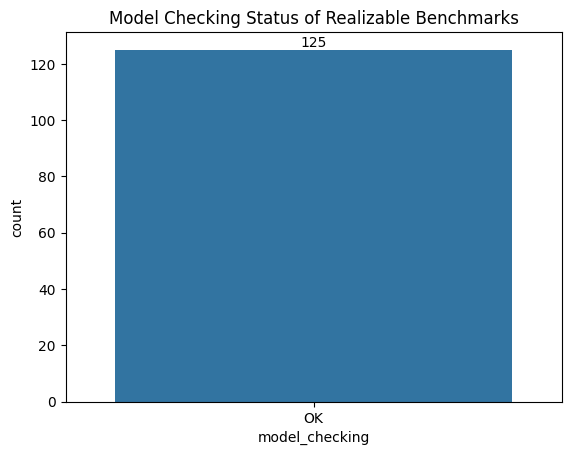

In [76]:
realizable_benchmarks = synt_deps_df[(synt_deps_df["is_completed"] == True) & (synt_deps_df["realizability"] != "UNREALIZABLE")]
ax = sns.countplot(x=realizable_benchmarks["model_checking"])
ax.bar_label(ax.containers[0]); ax.set_title("Model Checking Status of Realizable Benchmarks");